# First Part: Scipy Optimization

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
quandl.ApiConfig.api_key = 'AEmCsDtG-w32jUWxwov8'
stocks = ['BAC','BA','FB','GD','LMT','NVDA']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '1999-1-1', 'lte': '2017-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,1999-01-04,BA,21.977702
1,1999-01-05,BA,23.518944
2,1999-01-06,BA,24.059379
3,1999-01-07,BA,23.892578
4,1999-01-08,BA,23.892578


In [3]:
data4 = data

In [4]:
df = data4.set_index('date')
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,BA,BAC,FB,GD,LMT,NVDA
date,,,,,,
1999-01-04,21.977702,18.148592,NaN,20.252402,25.403941,NaN
1999-01-05,23.518944,18.391573,NaN,20.186838,25.836749,NaN
1999-01-06,24.059379,19.309502,NaN,20.186838,25.642299,NaN
1999-01-07,23.892578,20.266428,NaN,19.669227,25.015041,NaN
1999-01-08,23.892578,20.980372,NaN,19.344857,25.052677,NaN


In [5]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link(table, title = "Download CSV file", filename = "table.csv"):
    csv = table.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(table)

In [6]:
df = data4.set_index('date')
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,BA,BAC,FB,GD,LMT,NVDA
date,,,,,,
1999-01-04,21.977702,18.148592,NaN,20.252402,25.403941,NaN
1999-01-05,23.518944,18.391573,NaN,20.186838,25.836749,NaN
1999-01-06,24.059379,19.309502,NaN,20.186838,25.642299,NaN
1999-01-07,23.892578,20.266428,NaN,19.669227,25.015041,NaN
1999-01-08,23.892578,20.980372,NaN,19.344857,25.052677,NaN


Text(0,0.5,'price in $')

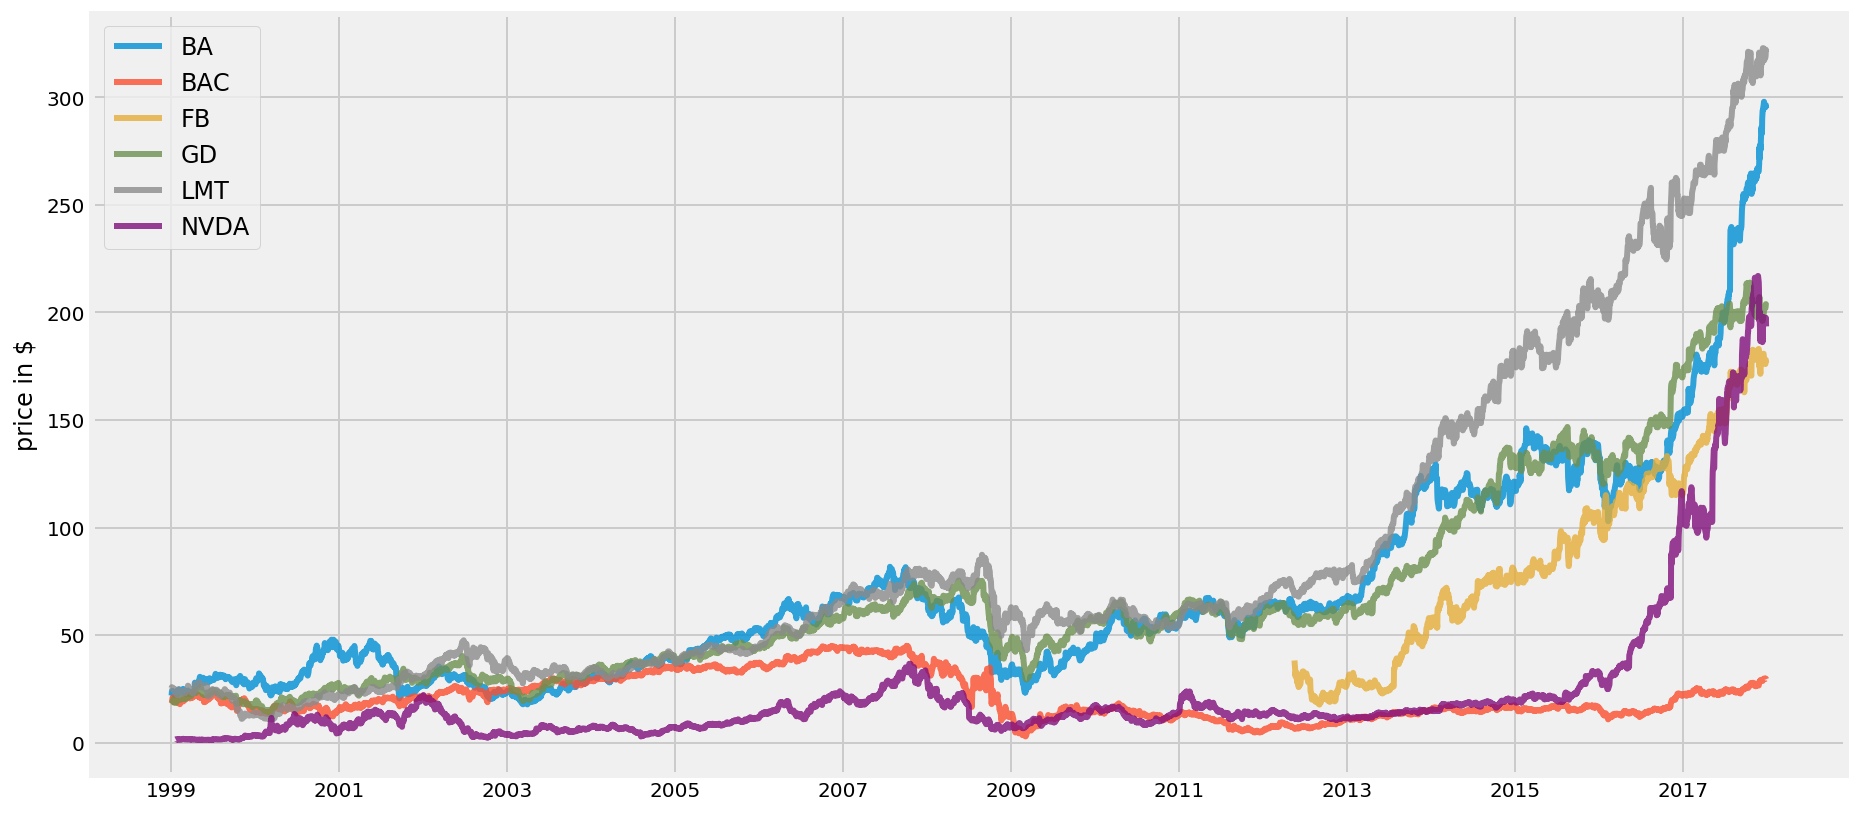

In [7]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0,0.5,'daily returns')

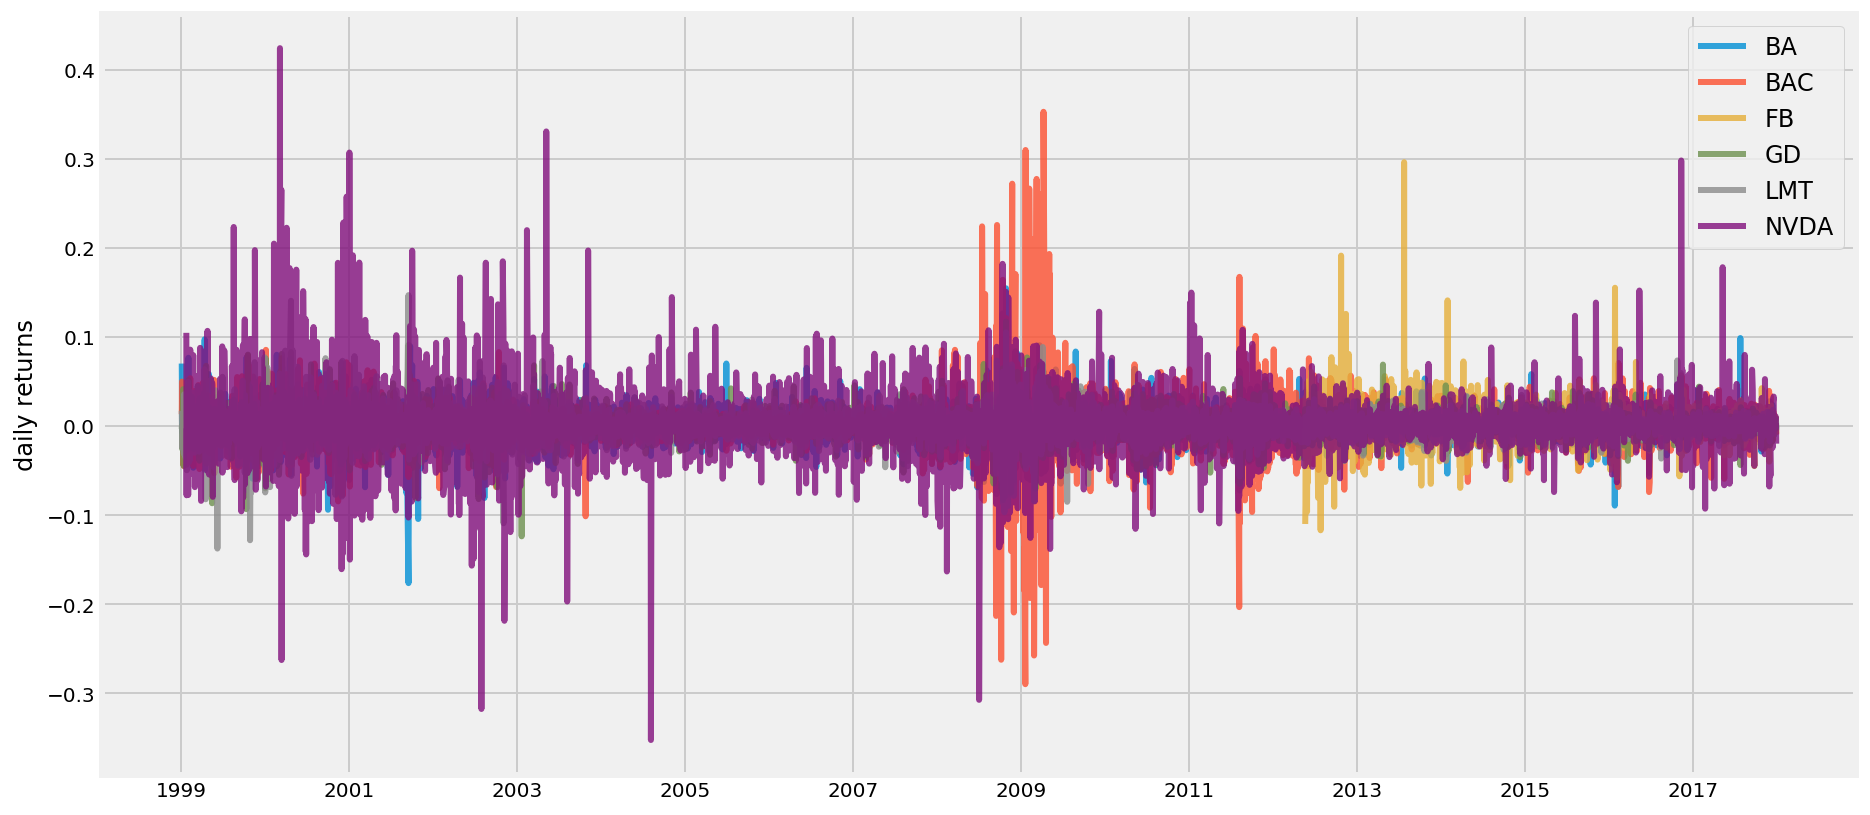

In [8]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [9]:

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in xrange(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [10]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 250000
risk_free_rate = 0.0178

In [11]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Annualised Return:", round(rp,2)
    print "Annualised Volatility:", round(sdp,2)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Annualised Return:", round(rp_min,2)
    print "Annualised Volatility:", round(sdp_min,2)
    print "\n"
    print min_vol_allocation
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(int "-"*80)? (<ipython-input-11-71c6531de0fb>, line 16)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.29
Annualised Volatility: 0.24


               BA   BAC     FB    GD    LMT   NVDA
allocation  10.57  0.24  44.26  6.98  22.86  15.09
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.2


               BA   BAC     FB     GD    LMT  NVDA
allocation  16.22  1.31  20.32  30.01  30.23  1.91


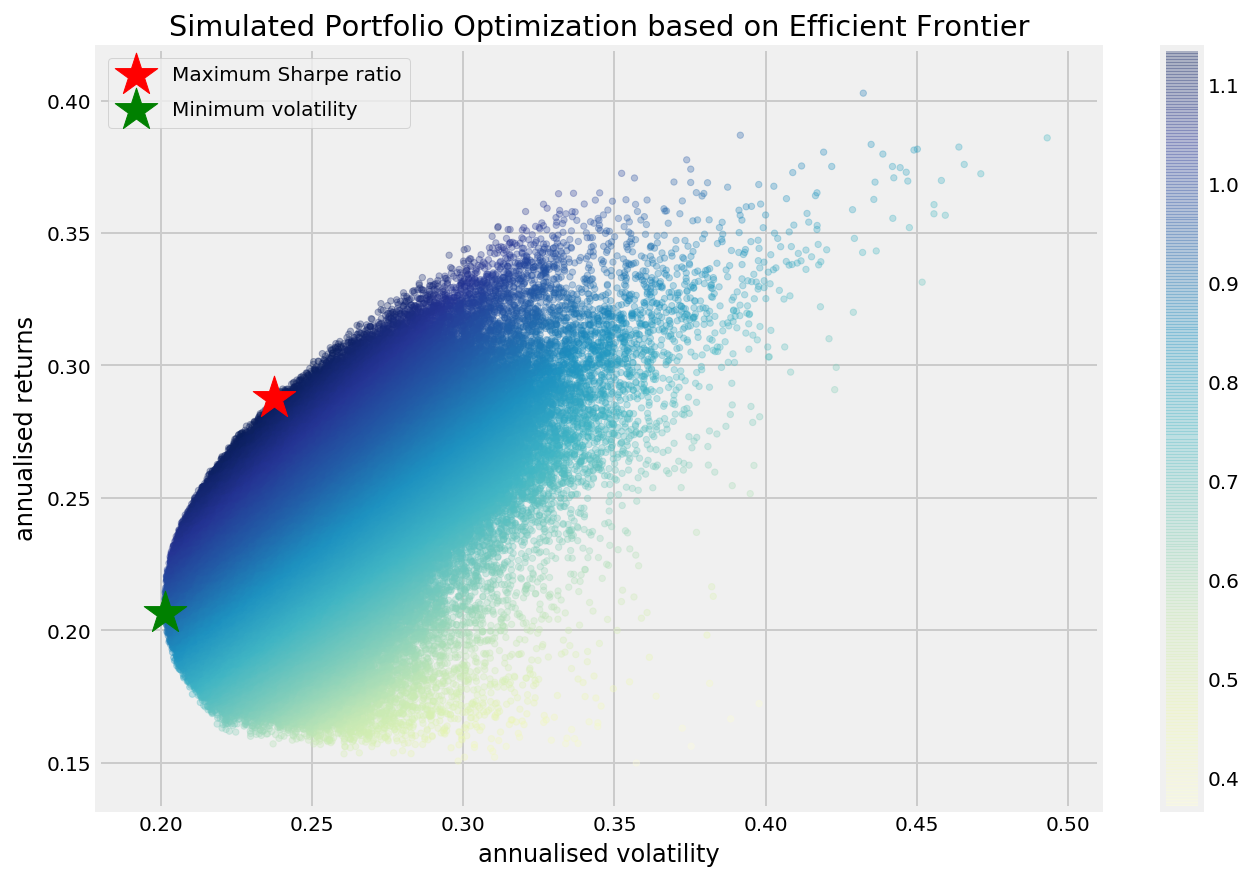

In [19]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


# Efficient Frontier

From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy's optimize function.

If you are an advanced Excel user, you might be familiar with 'solver' function in excel. Scipy's optimize function is doing the similar task when given what to optimize, and what are constraints and bounds.

In [ ]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [ ]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [ ]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [ ]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Annualised Return:", round(rp,2)
    print "Annualised Volatility:", round(sdp,2)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Annualised Return:", round(rp_min,2)
    print "Annualised Volatility:", round(sdp_min,2)
    print "\n"
    print min_vol_allocation
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [ ]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

We have almost the same result as what we have simulated by picking from the randomly generated portfolios. The slight difference is that the Scipy's "optimize" function has not allocated any budget at all for Google on maximum Sharpe ratio portfolio, while one we chose from the randomly generated samples has 0.45% of allocation for Google. There are some differences in the decimal places but more or less same.

In [ ]:
Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [ ]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Annualised Return:", round(rp,2)
    print "Annualised Volatility:", round(sdp,2)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Annualised Return:", round(rp_min,2)
    print "Annualised Volatility:", round(sdp_min,2)
    print "\n"
    print min_vol_allocation
    print "-"*80
    print "Individual Stock Returns and Volatility\n"
    for i, txt in enumerate(table.columns):
        print txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2)
    print "-"*80
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

In [ ]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)